In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.morphology import opening, dilation
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
import cv2

In [2]:
output_path = working_path = "/home/acucena/Documentos/UFPI/ICV/Resultado/"

#g = glob(output_path + 'maskedimages_*.npy')
#imgs = np.load(g[3])

In [77]:
img = imgs[162][0]
imgf = img.astype(np.float32)

In [78]:
coords_pix = np.where(imgf>0)

In [3]:
g = glob(output_path + '*.npy')


In [4]:
g

['/home/acucena/Documentos/UFPI/ICV/Resultado/fullimages_LIDC-IDRI-0091.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/SliceRegions_LIDC-IDRI-0091.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/maskedimages_LIDC-IDRI-0090.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/maskedimages_LIDC-IDRI-0088.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/maskedimages_LIDC-IDRI-0072.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/fullimages_LIDC-IDRI-0072.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/fullimages_LIDC-IDRI-0090.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/fullimages_LIDC-IDRI-0088.npy',
 '/home/acucena/Documentos/UFPI/ICV/Resultado/maskedimages_LIDC-IDRI-0091.npy']

In [5]:
imgs = np.load(g[8])

-70.75


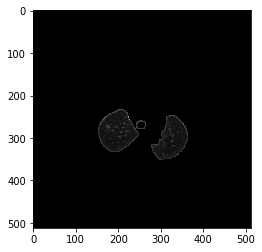

In [7]:
print(imgs[162][1])
plt.imshow(imgs[162][0], cmap='gray')
plt.show()

In [106]:
def seleciona_pixels_significativos(median, coords_pix):
    pix_list = []
    for i in range(len(coords_pix[0])):
        idx = coords_pix[0][i]
        idy = coords_pix[1][i]
        pix_list.append(median[idx][idy])
    return np.array(pix_list).reshape(-1,1)

In [119]:
def adiciona_labels_regioes(median, label, coords_pix):
    cont = 0
    fundo = np.zeros([512,512])
    for i in range(len(coords_pix[0])):
        idx = coords_pix[0][i]
        idy = coords_pix[1][i]
        fundo[idx][idy] = label[cont]+1
        cont = cont + 1
    return fundo

In [126]:
def aplica_kmeans(img):
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=1234)
    kmeans.fit(img)
    return kmeans.labels_

In [127]:
def gera_mascara_interna(img):
    
    imgf = img.astype(np.float32)
    median = cv2.medianBlur(imgf,7)
    coords_pix = np.where(median>0)
    reg_sig = seleciona_pixels_significativos(median, coords_pix)
    
    # Aplicação do k means com 2 clusters
    # Treino com o vetor de pixels
    # Pega lista de labels e redimensiona pra gerar uma máscara
    # Essa máscara mostra cada região de uma cor
    cluster_list = aplica_kmeans(reg_sig)
    mask_kmeans = adiciona_labels_regioes(median, cluster_list, coords_pix)
    
    # Criação de um fundo de zeros e plotagem da região de label 0
    fundo = np.zeros(img.shape,dtype=np.int8)
    fundo = fundo + np.where(mask_kmeans==1,1,0)
    
    fundo1 = np.zeros(img.shape,dtype=np.int8)
    fundo1 = fundo1 + np.where(mask_kmeans==2,1,0)
    _im = median * fundo1
    coords_pix = np.where(_im>0)
    reg_sig = seleciona_pixels_significativos(_im, coords_pix)
    
    cluster_list = aplica_kmeans(reg_sig)
    mask_kmeans = adiciona_labels_regioes(median, cluster_list, coords_pix)
    
    '''# Abertura morfológica para remoção de pequenas regiões claras
    abertura = opening(fundo)
    # Rotulação regiões conectadas seguida da aplicação do regionprops
    labels = label(abertura)
    props = regionprops(labels)

    good_labels = []
    # Utiliza a propriedade caixa delimitadora e alguns calculos para
    # identificar regiões importantes. Esses cálculos usam como base
    # a teoria de que a caixa dessas regiões importantes tendem
    # a ter um formato diferente das de outras regiões.
    for prop in props:
        B = prop.bbox 
        if B[2]-B[0]<img.shape[0]/10*9 and B[3]-B[1]<img.shape[1]/10*9 and B[0]>img.shape[0]/5 and B[2]<img.shape[0]/5*4:
            good_labels.append(prop.label)
    mask = np.zeros(img.shape,dtype=np.int8)
    # Geração de uma máscara com as regiões selecionadas anteriorimente
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    # Dilatação para preservar regiões internas importantes
    mask = dilation(mask)
    return mask'''
    return mask_kmeans

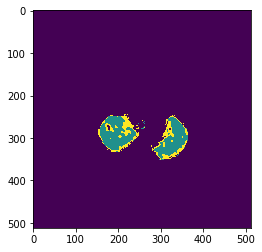

In [128]:
mask = gera_mascara_interna(img)
plt.imshow(mask)
plt.show()

In [124]:
seg = img*mask

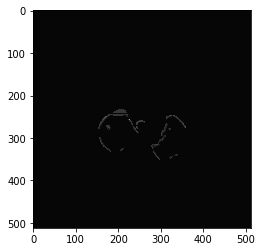

In [125]:
plt.imshow(seg, cmap='gray')
plt.show()

In [56]:
count = np.sum(median[:]<0)

In [37]:
count_tot = np.sum(img[:])

In [57]:
print(count)

168


In [40]:
fundo = np.zeros([512,512])
fundo = fundo + np.where(img<0,1,0)

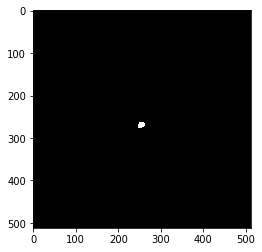

In [41]:
plt.imshow(fundo, cmap='gray')
plt.show()